Trying to use LLM to see the performance on train and test data

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#!pip install ctgan

In [ ]:
# !pip install sdv

In [ ]:
import pandas as pd
from datetime import datetime
import pickle
import numpy as np
import re
from sklearn.decomposition import PCA
import joblib
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split # fnding max_features
# from sklearn.ensemble import
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
# import joblib
import os

# hyperparameter tuning
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV #

from hyperopt import fmin, tpe, hp

import scipy.stats as stats

from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier # hp tunned
from sklearn.tree import DecisionTreeClassifier # hp tuned
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier #hp tuned
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
# from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

import spacy
import ast
import sklearn
import xgboost

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingClassifier, StackingClassifier

## under sampling
from imblearn.under_sampling import  RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour, TomekLinks, ClusterCentroids, RepeatedEditedNearestNeighbours, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, AllKNN, InstanceHardnessThreshold

## over sampling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler, SMOTENC

## over and under sampling
from imblearn.combine import SMOTEENN, SMOTETomek


## ctgan augmentation technique
# from sdv.single_table import CTGANSynthesizer
# from sdv.single_table import GaussianCopulaSynthesizer
# from sdv.single_table import TVAESynthesizer
# from sdv.metadata import Metadata
# from sdv.evaluation.single_table import run_diagnostic
# from sdv.evaluation.single_table import evaluate_quality


from sklearn.cluster import MiniBatchKMeans



In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
# compatability issue with xgboost

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
ERROR: Operation cancelled by user


In [ ]:
!pip show sklearn

In [ ]:
print(sklearn.__version__)
print(xgboost.__version__)

1.6.1
2.1.4


In [ ]:
dev_df_train = pd.read_csv('/content/drive/MyDrive/Thesis/data/dev/second_dev_train.csv')
df_train_org =  pd.read_csv('/content/drive/MyDrive/Thesis/data/train/new_11.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Thesis/data/test/english_test_11_2.csv') # unlabeled data
gold_test = pd.read_csv('/content/drive/MyDrive/Thesis/data/test/CT24_checkworthy_english_test_gold.tsv',delimiter='\t') # labeled data
dev_test = pd.read_csv('/content/drive/MyDrive/Thesis/data/dev/first_dev_test.csv')
data_to_merge = pd.read_csv('/content/drive/MyDrive/Thesis/data/train/ner_features_with_relevent_noise_prompt.csv')
test_tweet_f = pd.read_csv('/content/drive/MyDrive/Thesis/data/test/test_tweet_data_falcon_WL.csv')
test_tweet_g = pd.read_csv('/content/drive/MyDrive/Thesis/data/test/test_tweet_data_gemini_WL.csv')
tweet_test_wo = pd.read_csv('/content/drive/MyDrive/Thesis/data/test/tweet_test_WO_label.csv')

In [ ]:
vectorizer_path = '/content/drive/MyDrive/Thesis/models/tfidf_vectorizer_4300.pkl'
tfidf_vect = joblib.load(vectorizer_path)

pca_path = '/content/drive/MyDrive/Thesis/models/pca_356.pkl'
pca = joblib.load(pca_path)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid 

In [ ]:
df_train_org.drop('Unnamed: 0', axis = 1, inplace = True)
data_to_merge.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
data_to_merge.columns

Index(['Sentence_id', 'Text', 'class_label', 'CARDINAL', 'DATE', 'EVENT',
       'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL',
       'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME',
       'WORK_OF_ART', 'NONE', 'Noise_text', 'Relevant_text'],
      dtype='object')

In [ ]:
df_train_org['class_label'].value_counts()

,count
class_label,
No,17088
Yes,5413


In [ ]:
data_to_merge['class_label'].value_counts()

,count
class_label,
No,17088
Yes,5413


In [ ]:
data_to_merge[data_to_merge['NONE'] == True]['class_label'].value_counts()


,count
class_label,
No,9896
Yes,1254


In [ ]:
# 1. drop 9896 data from NO class
# 2. drop all NONE for all classes
after_drop = data_to_merge.drop(data_to_merge[(data_to_merge['class_label'] == 'No') & (data_to_merge['NONE'] == True)].index)
# after_drop = data_to_merge.drop(data_to_merge[(data_to_merge['NONE'] == True)].index)
after_drop.shape

(12605, 24)

In [ ]:
# merge the dataset
merged_data = pd.merge(df_train_org, after_drop, left_on='Sentence_id', right_on='Sentence_id', how='inner')

In [ ]:
merged_data.shape

(12605, 62)

In [ ]:
merged_data.columns

Index(['Sentence_id', 'Text_x', 'class_label_x', 'Tokens', 'text_length',
       'sentiment_score_veda', 'sentiment_score_textblob',
       'sentiment_score_bert', 'sentiment_score_roberta', 'bert_sent_neg',
       'bert_sent_pos', 'roberta_sent_neg', 'roberta_sent_neut',
       'roberta_sent_mixed', 'roberta_sent_pos', 'labels', 'names',
       'organizations', 'locations', 'dates', 'verbs', 'action_verbs',
       'filtered_action_verbs', 'joined_tokens', 'count_verb',
       'count_action_verb', 'count_filtered_action_verb', 'count_tokens',
       'cleaned_text', 'cleaned_text_length', 'contains_question_mark',
       'contains_exclamation', 'contains_ellipsis', 'num_exclamations',
       'num_questions', 'num_ellipses', 'punctuation_count',
       'converted_embedding', 'text-tfidf', 'Text_y', 'class_label_y',
       'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC',
       'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT',
       'QUANTITY', 'TIME'

In [ ]:
merged_data.drop(['Text_y', 'class_label_y','CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC','MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT','QUANTITY', 'TIME', 'WORK_OF_ART', 'NONE', 'Noise_text','Relevant_text'], axis = 1, inplace = True)

In [ ]:
merged_data.rename(columns={'Text_x': 'Text', 'class_label_x': 'class_label'}, inplace=True)

In [ ]:
merged_data.columns

Index(['Sentence_id', 'Text', 'class_label', 'Tokens', 'text_length',
       'sentiment_score_veda', 'sentiment_score_textblob',
       'sentiment_score_bert', 'sentiment_score_roberta', 'bert_sent_neg',
       'bert_sent_pos', 'roberta_sent_neg', 'roberta_sent_neut',
       'roberta_sent_mixed', 'roberta_sent_pos', 'labels', 'names',
       'organizations', 'locations', 'dates', 'verbs', 'action_verbs',
       'filtered_action_verbs', 'joined_tokens', 'count_verb',
       'count_action_verb', 'count_filtered_action_verb', 'count_tokens',
       'cleaned_text', 'cleaned_text_length', 'contains_question_mark',
       'contains_exclamation', 'contains_ellipsis', 'num_exclamations',
       'num_questions', 'num_ellipses', 'punctuation_count',
       'converted_embedding', 'text-tfidf'],
      dtype='object')

In [ ]:
merged_data.head()
# For LLM fine tuning , I need only the text column, label column, so, save it in another csv
merged_data[['Sentence_id', 'Text', 'class_label']].to_csv('/content/drive/MyDrive/Thesis/data/train/data_llm_fine_tune.csv')

In [ ]:
dev_df_train.columns

Index(['Unnamed: 0', 'Sentence_id', 'Text', 'class_label', 'Tokens',
       'text_length', 'cleaned_text', 'cleaned_text_length',
       'roberta_sentiment', 'roberta_sent_pos', 'roberta_sent_neg',
       'roberta_sent_mixed', 'roberta_sentiment_class', 'count_tokens',
       'counts', 'names', 'organizations', 'dates', 'punctuation_count',
       'embedding', 'converted_embedding', 'flattened_embedding', 'label',
       'joined_tokens', 'text-tfidf'],
      dtype='object')

In [ ]:
# dev_df_train[dev_df_train['text-tfidf'].isnull() == True]
# dropping the columns with nan values -- noisy data
dev_df_train = dev_df_train.dropna()
df_train_org = df_train_org.dropna()
merged_data = merged_data.dropna()
# dev_df_train.shape

In [ ]:
# merged_data.isna().any()
# merged_data[merged_data['Tokens'].isna() == True]
merged_data.shape

(12597, 39)

In [ ]:
print(type(merged_data['Tokens']))
print(type(merged_data['joined_tokens']))
print(type(merged_data['text-tfidf']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
merged_data[['Text', 'Tokens', 'joined_tokens', 'text-tfidf']].head()

,Text,Tokens,joined_tokens,text-tfidf
0,"Now, let's balance the budget and protect Medi...","['lets', 'balance', 'budget', 'protect', 'medi...",lets balance budget protect medicare medicaid ...,let balance budget protect medicare medicaid e...
1,I'd like to mention one thing.,"['id', 'mention', 'thing']",id mention thing,I d mention thing
2,I must remind him the Democrats have controlle...,"['must', 'remind', 'democrats', 'controlled', ...",must remind democrats controlled congress last...,must remind democrats control congress last tw...
3,I'm proud of the fact that violent crime is do...,"['im', 'proud', 'fact', 'violent', 'crime', 's...",im proud fact violent crime state texas,I m proud fact violent crime state texas
4,"If we're $4 trillion down, we should have ever...","['4', 'trillion', 'everything', 'perfect', 'do...",4 trillion everything perfect dont,4 trillion everything perfect do not


In [ ]:
# text = merged_data[merged_data['joined_tokens'].isna()][['Text','Tokens', 'joined_tokens', 'text-tfidf']]
# text

In [ ]:
# pattern = '\w+'
# txt = text['Text'].iloc[0]
# print(txt)
# match  = re.findall(pattern, txt)
# print(match)

I did not say that.
['I', 'did', 'not', 'say', 'that']


In [ ]:
# def tokens_func(row):
#   pattern = r'\w+'
#   # print(row['Text'])
#   if pd.isna(row['Tokens']):
#     match  = re.findall(pattern, row['Text'])
#     print(match)
#     return match
#   else:
#     return row['Tokens']



In [ ]:
# text['Tokens'] = text.apply(tokens_func, axis = 1)
# text

I did not say that.
And only the US could do this.
I do not say that.
They should have been doing this for years.
I did not say that.
We are not doing that today.
He did not do so.
I did not say that.


,Text,Tokens,joined_tokens,text-tfidf
1259,I did not say that.,[],NaN,NaN
4499,And only the US could do this.,[],NaN,NaN
6639,I do not say that.,[],NaN,NaN
7176,They should have been doing this for years.,[],NaN,NaN
8142,I did not say that.,[],NaN,NaN
11004,We are not doing that today.,[],NaN,NaN
11660,He did not do so.,[],NaN,NaN
11678,I did not say that.,[],NaN,NaN


In [ ]:
# def joined_tokens_func(row):
#   if pd.isna(row['joined_tokens']):
#     return ' '.join(row['Tokens'])
#   else:
#     return row['joined_tokens']

In [ ]:
# text['joined_tokens'] = text.apply(joined_tokens_func, axis = 1)
# text

,Text,Tokens,joined_tokens,text-tfidf
1259,I did not say that.,[],[ ],NaN
4499,And only the US could do this.,[],[ ],NaN
6639,I do not say that.,[],[ ],NaN
7176,They should have been doing this for years.,[],[ ],NaN
8142,I did not say that.,[],[ ],NaN
11004,We are not doing that today.,[],[ ],NaN
11660,He did not do so.,[],[ ],NaN
11678,I did not say that.,[],[ ],NaN


In [ ]:
# for handling empty tfidf
# def handle_empty_tfidf(row):
#   if pd.isna(row['Tokens']):
#       return row['Text']

#   else:
#     return ' '.join(row['Tokens'])



In [ ]:
# handle empty tokens
# def handle_empty_tokens(row):
#   if pd.isna(row['Tokens']):
#     return row['Text'].split(' ')

In [ ]:
merged_data.columns

Index(['Sentence_id', 'Text', 'class_label', 'Tokens', 'text_length',
       'sentiment_score_veda', 'sentiment_score_textblob',
       'sentiment_score_bert', 'sentiment_score_roberta', 'bert_sent_neg',
       'bert_sent_pos', 'roberta_sent_neg', 'roberta_sent_neut',
       'roberta_sent_mixed', 'roberta_sent_pos', 'labels', 'names',
       'organizations', 'locations', 'dates', 'verbs', 'action_verbs',
       'filtered_action_verbs', 'joined_tokens', 'count_verb',
       'count_action_verb', 'count_filtered_action_verb', 'count_tokens',
       'cleaned_text', 'cleaned_text_length', 'contains_question_mark',
       'contains_exclamation', 'contains_ellipsis', 'num_exclamations',
       'num_questions', 'num_ellipses', 'punctuation_count',
       'converted_embedding', 'text-tfidf'],
      dtype='object')

In [ ]:
# merged_data['text_tfidf_new'] = merged_data.apply(handle_empty_tfidf, axis=1)
# merged_data.drop(['text-tfidf', 'text-tfidf'], axis = 1, inplace = True)
# merged_data.rename(columns={'text_tfidf_new': 'text-tfidf'}, inplace=True)

In [ ]:
# merged_data.drop('text-tfidf',inplace = True)

In [ ]:
# first_dev_train.sample()
# df_train_org.drop('Unnamed: 0', axis=1, inplace=True)
dev_df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# df_train_org['converted_embedding'].iloc[0]
def convert_to_numpy_array(embd_str):
    #print(f"string: {embd_str}")
    #print(type(embd_str))
    embd_str_clean = embd_str.replace("\n", " ").replace(" ", " ")
    #print(type(embd_str_clean))
    #print(f"string cleansing: {embd_str_clean}")
    embd_str_clean = embd_str_clean.strip('[]')
    #print(type(embd_str_clean))
    #print(f"removing the outer brackets {embd_str_clean}")
    embd_list = embd_str_clean.split()
    #print(f"Split the string into individual values {embd_list}")
    embed_array = np.array(embd_list, dtype = float)
    #print(f"list to array {embed_array}")
    return embed_array

In [ ]:
## 8.03.25
best_param_rfc = {
 'bootstrap': False,
 'ccp_alpha': 0.01,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1788
}

best_param_xgb = {
 'colsample_bytree': 1.0,
 'eval_metric': 'logloss',
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 30,
 'min_child_weight': 5,
 'n_estimators': 1742,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 0.01,
 'scale_pos_weight': 5,
 'subsample': 0.6
}

best_param_dt = {
 'ccp_alpha': 0.01,
 'class_weight': 'balanced',
 'criterion': 'log_loss',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'
}

best_param_knn = {
   'metric': 'minkowski',
   'n_neighbors': 3,
   'p': 2,
   'weights': 'distance'
}

best_param_gdb = {
 'learning_rate': 0.27616382277289797,
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 16,
 'n_estimators': 255,
 'subsample': 0.9244569121330419
}

best_param_lgbm = {
 'bagging_fraction': 0.856135294962221,
 'bagging_freq': 4,
 'feature_fraction': 0.6424202471887338,
 'lambda_l1': 0.036886947354532795,
 'lambda_l2': 0.6095643339798968,
 'learning_rate': 0.16080370696865845,
 'max_depth': 8,
 'min_child_samples': 32,
 'n_estimators': 278,
 'num_leaves': 20
}

best_param_adb = {
  'learning_rate': 0.34370861113902185,
  'n_estimators': 153
}
# new_best_params = {

# }

- eval start

In [ ]:
dev_df_train['converted_embedding'] = dev_df_train['embedding'].apply(convert_to_numpy_array)

In [ ]:
# dev_df_train['converted_embedding'].iloc[0].shape

In [ ]:
# pca = PCA(n_components = 50)
dev_reduced_embeddings = pca.transform(dev_df_train['converted_embedding'].to_list())

In [ ]:

dev_text = dev_df_train['text-tfidf']
dev_tfidf_features = tfidf_vect.transform(dev_text)

In [ ]:
dev_additional_features = dev_df_train[['text_length', 'roberta_sent_neg', 'roberta_sent_mixed',
                            'roberta_sent_pos', 'names', 'organizations', 'dates',
                            'count_tokens', 'cleaned_text_length', 'punctuation_count']].to_numpy()

In [ ]:
dev_embeddings_np = np.array(dev_reduced_embeddings)
dev_tfidf_features_np = dev_tfidf_features.toarray()
dev_additional_features_np = np.array(dev_additional_features)

In [ ]:
# X_eval = np.hstack([dev_tfidf_features_np,dev_embeddings_np, dev_additional_features_np])
# # X_eval = np.hstack([dev_embeddings_np])
# y_eval = dev_df_train['label']

In [ ]:
# X_eval.shape

- eval end

- train start

In [ ]:

# df_train_org[df_train_org['text-tfidf'].isnull() == True]
# drop 116 rows - noisy data
# df_train_org = df_train_org.dropna()
merged_data = merged_data.dropna()


In [ ]:
merged_data.shape

(12597, 39)

In [ ]:
# df_train_org.columns
merged_data.columns

Index(['Sentence_id', 'Text', 'class_label', 'Tokens', 'text_length',
       'sentiment_score_veda', 'sentiment_score_textblob',
       'sentiment_score_bert', 'sentiment_score_roberta', 'bert_sent_neg',
       'bert_sent_pos', 'roberta_sent_neg', 'roberta_sent_neut',
       'roberta_sent_mixed', 'roberta_sent_pos', 'labels', 'names',
       'organizations', 'locations', 'dates', 'verbs', 'action_verbs',
       'filtered_action_verbs', 'joined_tokens', 'count_verb',
       'count_action_verb', 'count_filtered_action_verb', 'count_tokens',
       'cleaned_text', 'cleaned_text_length', 'contains_question_mark',
       'contains_exclamation', 'contains_ellipsis', 'num_exclamations',
       'num_questions', 'num_ellipses', 'punctuation_count',
       'converted_embedding', 'text-tfidf'],
      dtype='object')

In [ ]:
#df_train_org.drop('Unnamed: 0', axis=1, inplace=True)
# 'Sentence_id', converted_embedding, text-tfidf, 'text_length', 'roberta_sent_neg', 'roberta_sent_mixed',
#                             'roberta_sent_pos', 'names', 'organizations', 'dates',
#                             'count_tokens', 'cleaned_text_length', 'punctuation_count', labels


In [ ]:
# df_train_org['converted_embedding'] = df_train_org['converted_embedding'].apply(convert_to_numpy_array)
merged_data['converted_embedding'] = merged_data['converted_embedding'].apply(convert_to_numpy_array)

In [ ]:
# pca = PCA(n_components = 356)
train_reduced_embeddings = pca.transform(merged_data['converted_embedding'].to_list())

In [ ]:
merged_data['text-tfidf'].iloc[0]

'let balance budget protect medicare medicaid education environment'

In [ ]:
train_text = merged_data['text-tfidf']
# text = df_train_org['text-tfidf']
# vectorizer_path = '/content/drive/MyDrive/Thesis/models/tfidf_vectorizer_4300.pkl'
# tfidf_vect = joblib.load(vectorizer_path)
tfidf_features = tfidf_vect.transform(train_text)

In [ ]:
train_additional_features = merged_data[['text_length', 'roberta_sent_neg', 'roberta_sent_mixed',
                            'roberta_sent_pos', 'names', 'organizations', 'dates',
                            'count_tokens', 'cleaned_text_length', 'punctuation_count']].to_numpy()

In [ ]:
train_embeddings_np = np.array(train_reduced_embeddings)
# tfidf_features = tfidf_vect.transform(train_text)
train_tfidf_features_np = tfidf_features.toarray()
train_additional_features_np = np.array(train_additional_features)

In [ ]:
# for i in train_tfidf_features_np[merged_data.index[1]]:
#   print(i)
print(type(train_tfidf_features_np))
print(train_tfidf_features_np.shape)
#print(train_tfidf_features_np[0:3, :].shape)

<class 'numpy.ndarray'>
(12597, 4300)


In [ ]:
#print(train_tfidf_features_np[0].shape)
for i in set(train_tfidf_features_np[0]):
 # if i!= 0:
  print(i)

0.0
0.2738056866840556
0.205799406499117
0.25237436615415526
0.35846409024184483
0.2084350122924314
0.3472846813469176
0.26963809422423296
0.17699785353044922
0.28474145659621763
0.3284177066061944
0.23633729334921458
0.22161965603949954


In [ ]:
X_train = np.hstack([train_tfidf_features_np,train_embeddings_np, train_additional_features_np])
y_train = merged_data['labels']

In [ ]:
X_train.shape

(12597, 4666)

In [ ]:
train_additional_features

array([[9.20000000e+01, 1.09835215e-01, 7.49124229e-01, ...,
        8.00000000e+00, 8.70000000e+01, 5.00000000e+00],
       [3.00000000e+01, 4.29293849e-02, 2.77310073e-01, ...,
        3.00000000e+00, 2.80000000e+01, 2.00000000e+00],
       [1.24000000e+02, 3.17872703e-01, 3.52120519e-01, ...,
        9.00000000e+00, 1.22000000e+02, 2.00000000e+00],
       ...,
       [9.40000000e+01, 7.31740445e-02, 5.19856811e-01, ...,
        7.00000000e+00, 9.20000000e+01, 2.00000000e+00],
       [7.30000000e+01, 7.46450603e-01, 1.55407131e-01, ...,
        3.00000000e+00, 7.20000000e+01, 1.00000000e+00],
       [5.40000000e+01, 1.75571442e-01, 7.34495163e-01, ...,
        5.00000000e+00, 5.20000000e+01, 2.00000000e+00]])

In [ ]:
y_train.value_counts()

,count
labels,
0,7189
1,5408


## UNDERSAMPLING TECHNIQUES

In [ ]:
from imblearn.under_sampling import  RandomUnderSampler, EditedNearestNeighbours, CondensedNearestNeighbour, TomekLinks, ClusterCentroids, RepeatedEditedNearestNeighbours, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, AllKNN, InstanceHardnessThreshold

rus = RandomUnderSampler(sampling_strategy='majority',random_state = 42)

enn = EditedNearestNeighbours(sampling_strategy='not minority', n_neighbors = 4, n_jobs = -1, kind_sel='mode')

tml_1 = TomekLinks(sampling_strategy='majority', n_jobs = -1)
tml_2 = TomekLinks(sampling_strategy='not minority', n_jobs = -1)

cnn_1 = CondensedNearestNeighbour(sampling_strategy='majority',random_state = 42, n_jobs = -1)
cnn_2 = CondensedNearestNeighbour(sampling_strategy='not minority',random_state = 42, n_jobs = -1, n_neighbors=4, n_seeds_S=20)

cc_1 = ClusterCentroids(sampling_strategy='majority',random_state = 42)
cc_2 = ClusterCentroids(sampling_strategy='auto',random_state = 42, voting = 'soft')

renn_1 = RepeatedEditedNearestNeighbours(sampling_strategy='majority',n_jobs = -1)
renn_2 = RepeatedEditedNearestNeighbours(sampling_strategy= 'auto',n_neighbors=    4,  kind_sel= 'mode',  max_iter= 100  )


nm_1 = NearMiss(sampling_strategy='majority',n_jobs = -1)
nm_2 = NearMiss(sampling_strategy='auto',n_jobs = -1, version = 3, n_neighbors = 4, n_neighbors_ver3=5)

ncr = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors = 3, n_jobs = -1)

aiiknn = AllKNN(sampling_strategy = 'auto', n_neighbors = 3, kind_sel = 'mode', allow_minority = True, n_jobs = -1)

iht = InstanceHardnessThreshold(estimator=XGBClassifier(**best_param_xgb), cv = 5, sampling_strategy = 'auto', n_jobs = -1)

os = OneSidedSelection(sampling_strategy = 'auto', n_neighbors = 4,  n_jobs = -1)






X_train_u_balanced_rus, y_train_u_balanced_rus = rus.fit_resample(X_train, y_train)

X_train_u_balanced_enn, y_train_u_balanced_enn = enn.fit_resample(X_train, y_train)

X_train_u_balanced_tml_1, y_train_u_balanced_tml_1 = tml_1.fit_resample(X_train, y_train)
X_train_u_balanced_tml_2, y_train_u_balanced_tml_2 = tml_2.fit_resample(X_train, y_train)

-------CNN START----------------------------------------------------------------------------------
# CNN taking much time with 4666 features -  so decided to balance the data with only embeddings

X, y = cnn_1.fit_resample(train_embeddings_np, y_train)
filtered_index = cnn_1.sample_indices_
X_train_u_balanced_cnn_1 = X_train[filtered_index]
y_train_u_balanced_cnn_1 = y_train.iloc[filtered_index]

X, y = cnn_2.fit_resample(train_embeddings_np, y_train)
filtered_index = cnn_2.sample_indices_
X_train_u_balanced_cnn_2 = X_train[filtered_index]
y_train_u_balanced_cnn_2 = y_train.iloc[filtered_index]
print(filtered_index.shape)
# ------CNN END--------------------------------------------------------------------------------------

X_train_u_balanced_cc_1, y_train_u_balanced_cc_1 = cc_1.fit_resample(X_train, y_train)
X_train_u_balanced_cc_2, y_train_u_balanced_cc_2 = cc_2.fit_resample(X_train, y_train)

X_train_u_balanced_renn_1, y_train_u_balanced_renn_1 = renn_1.fit_resample(X_train, y_train)
X_train_u_balanced_renn_2, y_train_u_balanced_renn_2 = renn_2.fit_resample(X_train, y_train)

X_train_u_balanced_nm_1, y_train_u_balanced_nm_1 = nm_1.fit_resample(X_train, y_train)
X_train_u_balanced_nm_2, y_train_u_balanced_nm_2 = nm_2.fit_resample(X_train, y_train)

X_train_u_balanced_ncr, y_train_u_balanced_ncr = ncr.fit_resample(X_train, y_train)

X_train_u_balanced_aiiknn, y_train_u_balanced_aiiknn = aiiknn.fit_resample(X_train, y_train)

X_train_u_balanced_iht, y_train_u_balanced_iht = iht.fit_resample(X_train, y_train)

X_train_u_balanced_os, y_train_u_balanced_os = os.fit_resample(X_train, y_train)

In [ ]:
saving different undersampled data for letter use (time saving)
with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_rus_majority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_rus, y_train_u_balanced_rus), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_enn_not_minority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_enn, y_train_u_balanced_enn), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cnn_majority.pkl', 'wb') as f:
    pickle.dump((X_train_u_balanced_cnn_1, y_train_u_balanced_cnn_1), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cnn_auto.pkl', 'wb') as f:
    pickle.dump((X_train_u_balanced_cnn_2, y_train_u_balanced_cnn_2), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_tml_majority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_tml_1, y_train_u_balanced_tml_1), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_tml_not_minority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_tml_2, y_train_u_balanced_tml_2), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cc_majority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_cc_1, y_train_u_balanced_cc_1), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cc_not_minority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_cc_2, y_train_u_balanced_cc_2), f)


with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_renn_majority.pkl', 'wb') as f:
    pickle.dump((X_train_u_balanced_renn_1, y_train_u_balanced_renn_1), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_renn_auto.pkl', 'wb') as f:
    pickle.dump((X_train_u_balanced_renn_2, y_train_u_balanced_renn_2), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_ncr_auto.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_ncr, y_train_u_balanced_ncr), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_nm_majority.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_nm_1, y_train_u_balanced_nm_1), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_nm_auto.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_nm_2, y_train_u_balanced_nm_2), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_aiiknn_auto.pkl', 'wb') as f:
    pickle.dump((X_train_u_balanced_aiiknn, y_train_u_balanced_aiiknn), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_iht_auto_xgb_best_param.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_iht, y_train_u_balanced_iht), f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_os_auto.pkl', 'wb') as f:
     pickle.dump((X_train_u_balanced_os, y_train_u_balanced_os), f)








# load the pickel file


with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_rus_majority.pkl', 'rb') as f:
    X_train_u_balanced_rus_majority, y_train_u_balanced_rus_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_enn_not_minority.pkl', 'rb') as f:
    X_train_u_balanced_enn_not_minority, y_train_u_balanced_enn_not_minority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cnn_majority.pkl', 'rb') as f:
    X_train_u_balanced_cnn_majority, y_train_u_balanced_cnn_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cnn_auto.pkl', 'rb') as f:
    X_train_u_balanced_cnn_auto, y_train_u_balanced_cnn_auto = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_tml_majority.pkl', 'rb') as f:
    X_train_u_balanced_tml_majority, y_train_u_balanced_tml_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_tml_not_minority.pkl', 'rb') as f:
     X_train_u_balanced_tml_not_minority, y_train_u_balanced_tml_not_minority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cc_majority.pkl', 'rb') as f:
     X_train_u_balanced_cc_majority, y_train_u_balanced_cc_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_cc_not_minority.pkl', 'rb') as f:
    X_train_u_balanced_cc_not_minority, y_train_u_balanced_cc_not_minority = pickle.load(f)


with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_renn_majority.pkl', 'rb') as f:
    X_train_u_balanced_renn_majority, y_train_u_balanced_renn_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_renn_auto.pkl', 'rb') as f:
     X_train_u_balanced_renn_auto, y_train_u_balanced_renn_auto = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_ncr_auto.pkl', 'rb') as f:
     X_train_u_balanced_ncr_auto, y_train_u_balanced_ncr_auto = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_nm_majority.pkl', 'rb') as f:
     X_train_u_balanced_nm_majority, y_train_u_balanced_nm_majority = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_nm_auto.pkl', 'rb') as f:
     X_train_u_balanced_nm_auto, y_train_u_balanced_nm_auto = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_aiiknn_auto.pkl', 'rb') as f:
    X_train_u_balanced_aiiknn_auto, y_train_u_balanced_aiiknn_auto = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_iht_auto_xgb_best_param.pkl', 'rb') as f:
    X_train_u_balanced_iht_auto_xgb_best_param, y_train_u_balanced_iht_auto_xgb_best_param = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/under_balanced_os_auto.pkl', 'rb') as f:
    X_train_u_balanced_os_auto, y_train_u_balanced_os_auto = pickle.load(f)





### OVERSAMPLING TECHNIQUES

In [ ]:
ros = RandomOverSampler(sampling_strategy = 'auto', random_state = 42)
smote = SMOTE(sampling_strategy = 'auto', random_state = 42, k_neighbors=5)
adasyn = ADASYN(sampling_strategy = 'auto', random_state = 42, n_neighbors = 5)
borderlinesmote = BorderlineSMOTE(sampling_strategy = 'auto', random_state = 42, k_neighbors = 5, m_neighbors = 10, kind = 'borderline-1')
kmeansmote = KMeansSMOTE(sampling_strategy = 'auto', random_state = 42, k_neighbors = 2, cluster_balance_threshold=0.01, density_exponent='auto', kmeans_estimator=MiniBatchKMeans(n_clusters=10, random_state=42))
svmsmote = SVMSMOTE(sampling_strategy = 'auto', random_state = 42, k_neighbors = 5, m_neighbors=10, out_step=0.5)



In [ ]:
X_train_o_balanced_ros, y_train_o_balanced_ros = ros.fit_resample(X_train, y_train)
X_train_o_balanced_smote, y_train_o_balanced_smote = smote.fit_resample(X_train, y_train)
X_train_o_balanced_adasyn, y_train_o_balanced_adasyn = adasyn.fit_resample(X_train, y_train)
X_train_o_balanced_borderlinesmote, y_train_o_balanced_borderlinesmote = borderlinesmote.fit_resample(X_train, y_train)
X_train_o_balanced_kmeansmote, y_train_o_balanced_kmeansmote = kmeansmote.fit_resample(X_train, y_train)
X_train_o_balanced_svmsmote, y_train_o_balanced_svmsmote = svmsmote.fit_resample(X_train, y_train)

In [ ]:
saving different oversampled data for letter use (time saving)
with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_ros_auto.pkl', 'wb') as f:
     pickle.dump((X_train_o_balanced_ros, y_train_o_balanced_ros), f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_smote_auto.pkl', 'wb') as f:
     pickle.dump((X_train_o_balanced_smote, y_train_o_balanced_smote), f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_adasyn_auto.pkl', 'wb') as f:
    pickle.dump((X_train_o_balanced_adasyn, y_train_o_balanced_adasyn), f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_borderline_auto.pkl', 'wb') as f:
    pickle.dump((X_train_o_balanced_borderlinesmote, y_train_o_balanced_borderlinesmote), f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_kmeansmote_auto.pkl', 'wb') as f:
     pickle.dump((X_train_o_balanced_kmeansmote, y_train_o_balanced_kmeansmote), f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_svm_smote.pkl', 'wb') as f:
     pickle.dump((X_train_o_balanced_svmsmote, y_train_o_balanced_svmsmote), f)


with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_ros_auto.pkl', 'rb') as f:
    X_train_o_balanced_ros, y_train_o_balanced_ros = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_smote_auto.pkl', 'rb') as f:
    X_train_o_balanced_smote, y_train_o_balanced_smote = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_adasyn_auto.pkl', 'rb') as f:
    X_train_o_balanced_adasyn, y_train_o_balanced_adasyn = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_borderline_auto.pkl', 'rb') as f:
    X_train_o_balanced_borderlinesmote, y_train_o_balanced_borderlinesmote = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_kmeansmote_auto.pkl', 'rb') as f:
    X_train_o_balanced_kmeansmote, y_train_o_balanced_kmeansmote = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/over_balanced_svm_smote.pkl', 'rb') as f:
     X_train_o_balanced_svmsmote, y_train_o_balanced_svmsmote = pickle.load(f)

## MIXED SAMPLING TECHNIQUES

In [ ]:
smoteenn = SMOTEENN(sampling_strategy = 'auto', random_state = 42, n_jobs = None, smote=None, enn=None)
smotetomek = SMOTETomek(sampling_strategy = 'auto', random_state = 42, n_jobs = -1)

In [ ]:
X_train_mixed_balanced_smoteenn, y_train_mixed_balanced_smoteenn = smoteenn.fit_resample(X_train, y_train)
X_train_mixed_balanced_smotetomek, y_train_mixed_balanced_smotetomek = smotetomek.fit_resample(X_train, y_train)

In [ ]:
saving different mixedsample data for letter use (time saving)
with open('/content/drive/MyDrive/Thesis/data/train/mixed_balanced_smoteenn_auto.pkl', 'wb') as f:
     pickle.dump((X_train_mixed_balanced_smoteenn, y_train_mixed_balanced_smoteenn), f)

with open('/content/drive/MyDrive/Thesis/data/train/mixed_balanced_smotetomek_auto.pkl', 'wb') as f:
     pickle.dump((X_train_mixed_balanced_smotetomek, y_train_mixed_balanced_smotetomek), f)



with open('/content/drive/MyDrive/Thesis/data/train/mixed_balanced_smoteenn_auto.pkl', 'rb') as f:
    X_train_mixed_balanced_smoteenn, y_train_mixed_balanced_smoteenn = pickle.load(f)

with open('/content/drive/MyDrive/Thesis/data/train/mixed_balanced_smotetomek_auto.pkl', 'rb') as f:
    X_train_mixed_balanced_smotetomek, y_train_mixed_balanced_smotetomek = pickle.load(f)



### CTGAN for augmentation

In [ ]:
# !pip install ctgan

# get the minority data
# generate tfidf for minority
# generate pca for minority
# stack them to make dataet
# generate new data


In [ ]:
# minority_data = merged_data[merged_data["labels"] == 1]["Text"]
# # print(minority_data.shape)

# # # minority_tfidf = train_additional_features_np[minority_data.index]
# # type(minority_data)
# print(minority_data.index)

Index([    2,     3,     4,     5,     6,     9,    11,    14,    16,    17,
       ...
       12591, 12594, 12595, 12596, 12598, 12599, 12600, 12601, 12602, 12603],
      dtype='int64', length=5408)


In [ ]:

# minority_data = minority_data.to_frame()

In [ ]:
# minority_data.sample(5)

In [ ]:
# metadata = Metadata.detect_from_dataframe(
#     data = minority_data,
#     table_name = 'describe'
# )

In [ ]:
# ctgan_synth = CTGANSynthesizer(metadata)
# ctgan_synth.fit(minority_data)

# synthetic_data = ctgan_synth.sample(num_rows = 1785)

In [ ]:
# print(merged_data.shape)
# print(train_tfidf_features_np.shape)
# print(minority_data.shape)

In [ ]:
# minority_data.tail()

In [ ]:
# if merged_data[].index != minority_data.index:
# print(merged_data.index)
# print(minority_data.index)
# print(X_train.index)
# print(y_train.index)
# y_train_array = y_train.to_numpy()
new_train = np.hstack([X_train, merged_data["labels"].to_numpy().reshape(-1, 1)])

minority_array = []
majority_array = []
i = 0
for x in new_train:
  if x[-1] == 1.0:
    i += 1
    minority_array.append(x)
  else:
    majority_array.append(x)
# print(i)

In [ ]:
minority_array = np.array(minority_array, ndmin = 2) # making 2-dimensional
majority_array = np.array(minority_array, ndmin = 2) # making 2-dimensional

In [ ]:
df_minor = pd.DataFrame(minority_array) # converting to DataFrame
df_major = pd.DataFrame(majority_array) # converting to DataFrame

df_minor = df_minor.drop(df_minor.columns[-1], axis = 1) # Droping the last value, which is actually the label value
# df_minor

In [ ]:
print(df_minor.shape)
print(df_major.shape)

(5408, 4666)
(5408, 4667)


In [ ]:
metadata = Metadata.detect_from_dataframe(df_minor)
metadata.save_to_json('/content/drive/MyDrive/Thesis/data/synthesizer_sdv/06_04.json') # saving the metadata for future use

In [ ]:
# metadata.visualize()

In [ ]:
# ctgan = CTGANSynthesizer(max_depth = 2, max_bin= 100, learning_rate = 0.02, n_estimators = 500)

ctgan = CTGANSynthesizer(metadata)

ctgan.fit(df_minor)

synthetic_data = ctgan.sample(num_rows = 1785)
synthetic_data.head()

#----------------------------------------

# synthetic data --  add column with all 1
# synthetic_data['labels'] = 1
# concat row wise -- df_minor and synthetic_data -- shuffle or mixed up
# concated_df = pd.concat([df_minor, synthetic_data], axis = 0)

# merge df_major -- shuffle or mixed up
# final_marged_df = pd.concat([concated_df, df_major], axis = 0)

# shuffle the data
# concated_df = concated_df.sample(frac = 1)

#
# convert to X_train and y_train again
# syn_y_train = concated_df['labels'] # no need to conversion
# syn_X_train = concated_df.drop('labels', axis = 1) # need to conversion

# convert syn_x_train to np array -- should be look like this:
# X_train = np.hstack([train_tfidf_features_np,train_embeddings_np, train_additional_features_np])
# syn_X_train = syn_X_train.to_numpy()
# ----------------------------------------------

#---------------------VISUALIZE - SYNTHESIZED DATA; DF_MINOR; DF_MAJOR; AS CLUSTER TO SEE; IS SYNTHETIC DATA CLOSE TO MINOR OR MAJOR DATA ------


#---------------------------------------------------------------------
# convert to numpy array

# X_train_ctgan, y_train_ctgan = ctgan.fit(X_train, y_train, epochs = 100)
#synthesizer = CTGANSynthesizer(verbose=True)

# df_train_ctgan = pd.DataFrame(X_train)
# df_train_ctgan['target'] = y_train


#metadata.detect_from_dataframe(data=df_train_ctgan)
#metadata.visualize()
# print(df_train_ctgan['target'].value_counts())

# # seperating the majority and minority data, cause i want to synthesize only minority data set to match the size with majorry level data
# real_majority = df_train_ctgan[df_train_ctgan['target'] == 0]
# real_minority = df_train_ctgan[df_train_ctgan['target'] == 1]#
# print(real_majority.shape)
# print(real_minority.shape)

# # drop th target column
# real_minority_features = real_minority.drop('target', axis = 1)
# real_minority_target = real_minority[]
# # real_minority_features = real_minority.drop('target', axis = 1, inplace = True)

# print(real_minority_features.shape)

# # generating the clumn info
# metadata = SingleTableMetadata()
# metadata.detect_from_dataframe(data = real_minority_features)
# print(f"metadat save to json file\n")
# metadata.save_to_json('/content/drive/MyDrive/Thesis/data/synthesizer_sdv/1_metadata.json')
# print(f"saved")
# synthesizer = GaussianCopulaSynthesizer(metadata, enforce_min_max_values=True)
# # fit on real data to understand the pattern
# synthesizer.fit(real_minority_features)

# # save the synthesizer
# synthesizer.save('GCS_synthesizer.pkl')






/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name   Est # of Columns (CTGAN)
0                      11
1                      11
2                      11
3                      11
4                      11
5                      11
6                      11
7                      11
8                      11
9                      11
10                     11
11                     11
12                     11
13                     11
14                     11
15                     11
16                     11
17                     11
18                     11
19                     11
20                     11
21                     11
22                     11
23                     11
24                     11
25                     11
26                     11
27                     11
28                     11
29                     11
30                     11


KeyboardInterrupt: 

In [ ]:
# create synthesized data
synthetic_data = synthesizer.sample(num_rows = 1785)

### previously we have used X:train and y_train to synthesize, now we will do with the real dataframe

In [ ]:
df_minority = merged_data[merged_data['labels'] == 1]

In [ ]:
df_train_ctgan

,0,1,2,3,4,5,6,7,8,9,...,4657,4658,4659,4660,4661,4662,4663,4664,4665,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.109835,0.749124,0.109604,0.0,2.0,0.0,8.0,87.0,5.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042929,0.277310,0.083819,0.0,0.0,0.0,3.0,28.0,2.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.317873,0.352121,0.123883,0.0,1.0,0.0,9.0,122.0,2.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042912,0.682642,0.027030,0.0,0.0,0.0,7.0,69.0,2.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.084890,0.372827,0.530065,0.0,0.0,0.0,5.0,69.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.816519,0.014003,0.163159,0.0,1.0,0.0,22.0,321.0,7.0,0.0
12593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.773144,0.075351,0.139876,0.0,0.0,0.0,2.0,30.0,2.0,0.0
12594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.073174,0.519857,0.106593,0.0,0.0,1.0,7.0,92.0,2.0,1.0
12595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.746451,0.155407,0.085391,0.0,0.0,0.0,3.0,72.0,1.0,1.0


In [ ]:
with open('/content/drive/MyDrive/Thesis/data/train/balanced_ctgan.pkl', 'wb') as f:
     pickle.dump((X_train_ctgan, y_train_ctgan), f)


# with open('/content/drive/MyDrive/Thesis/data/train/balanced_ctgan.pkl', 'rb') as f:
#     X_train_ctgan, y_train_ctgan = pickle.load(f)



## Train with this data set - (17088 - 9896 = 7189), 5408 (not depricated 1254 data afetr NER recognition)

# 1. random forest classifier

In [ ]:
rfc_1 = RandomForestClassifier(**best_param_rfc, random_state = 42)
rfc_1.fit(X_train, y_train)

- under sampling the X_train data start

In [ ]:
# under sampling

from imblearn.over_sampling import RandomOverSampler


In [ ]:
# embeddings_np.shape

In [ ]:
print(type(X_train))
print(type(y_train))
print(type(train_embeddings_np))

NameError: name 'X_train' is not defined

In [ ]:

# # geting filtered indexes
filtered_indexes = cnn.sample_indices_
X_train_u_balanced_cnn = X_train[filtered_indexes]
y_train_u_balanced_cnn = y_train.iloc[filtered_indexes]

print(y_train_u_balanced_cnn.value_counts())

labels
1    5408
0    2890
Name: count, dtype: int64


In [ ]:
X_train_u_balanced_cnn.shape

(8298, 4666)

In [ ]:
print(type(X))
print(type(y))
print(y.value_counts())

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
labels
1    5408
0    2890
Name: count, dtype: int64


In [ ]:
print(X_train_u_balanced_cnn.shape)
print(y_train_u_balanced_cnn.shape)

(8298, 4666)
(8298,)


- under sampling the X_train data end

- train end

In [ ]:
# data = {
#     'cnn': y_train_u_balanced_cnn,
#     'enn': y_train_u_balanced_enn,
#     'rus': y_train_u_balanced_rus,
#     'tml': y_train_u_balanced_tml
# }

try:
    print(f"cnn: {y_train_u_balanced_cnn.value_counts()}")
except Exception as e:
    print(f"error: {e}")

try:
    print(f"enn: {y_train_u_balanced_enn.value_counts()}")
except Exception as e:
    print(f"error: {e}")


try:
    print(f"rus: {y_train_u_balanced_rus.value_counts()}")
except Exception as e:
    print(f"error: {e}")

try:
    print(f"tml: {y_train_u_balanced_tml.value_counts()}")
except Exception as e:
    print(f"error: {e}")

# for key, value in data.items():
#   try:
#     print(f"{key}: {value.value_counts()}")
#   except Exception as e:
#     print(f"error in {key, value}: {e}")

cnn: labels
1    5408
0    2890
Name: count, dtype: int64
enn: labels
1    5408
0    2973
Name: count, dtype: int64
rus: labels
0    5408
1    5408
Name: count, dtype: int64
tml: labels
0    6678
1    5408
Name: count, dtype: int64


In [ ]:
# print(X_eval.shape)
# print(X_train.shape)

### different under sampled data: 4 data sampling technique X 7 hp tuned model => 28 models

In [ ]:
# 8.03.25
# different under sampled data: 4 data samplin technique X 7 hp tuned model => 28 models
train_resampling_set = {
    "rus": (X_train_u_balanced_rus, y_train_u_balanced_rus),
    "cnn": (X_train_u_balanced_cnn, y_train_u_balanced_cnn),
    "tml": (X_train_u_balanced_tml, y_train_u_balanced_tml),
    "enn": (X_train_u_balanced_enn, y_train_u_balanced_enn)
}
# eval_set = [X_eval, y_eval] # for gradient boostin models
train_models_set = {} # store the models for testing on gold dataset
model_set = {
    "rfc": (RandomForestClassifier(), best_param_rfc),
    "xgb": (XGBClassifier(), best_param_xgb),
    "dt": (DecisionTreeClassifier(), best_param_dt),
    "knn": (KNeighborsClassifier(), best_param_knn),
    "gdb": (GradientBoostingClassifier(), best_param_gdb),
    "lgbm": (LGBMClassifier(), best_param_lgbm),
    "adb": (AdaBoostClassifier(), best_param_adb)
}
for resampling_name, (X, y) in train_resampling_set.items():
  X_train = X
  y_train = y
  print("#"*50)
  print(f"-------dataset is resampled with {resampling_name}----------\n\n")
  print("-"*50)
  print(f"Shape of the data: {X_train.shape()}\n")
  print(f"Data sample from different class: {y_train.value_counts()}\n")
  print("-"*50)
  for name, (model, params) in model_set.items():
    print(f"Start {name} at {datetime.now().strftime('%I-%M-%S')} \n")
    try:
      print('-'*50)
      print(f"name: {name}")
      print(f"model: {model}, params: {params}")
      print('-'*50)
      model.set_params(**params)
      model.fit(X_train, y_train)
      train_models_set[name + resampling_name] = model
      print("--------------------Models in train_model_set-------------------\n")
      for k, v in train_models_set.items():
        print(f"{k}: {v}\n")
      print("-"*50)
      print(f"{name} trained successfully at {datetime.now().strftime('%I-%M-%S')}\n")
    except Exception as e:
      print(f"error for this {name}: {e}\n")


-----------------------------------------------------------------

-------dataset is resampled with rus----------


Start rfc at 02-45-03 

Trained model stored till now: <built-in method keys of dict object at 0x7da6f8c9aa80>

rfc trained successfully at 02-45-53

Start xgb at 02-45-53 

Trained model stored till now: <built-in method keys of dict object at 0x7da6f8c9aa80>

xgb trained successfully at 03-02-19

Start dt at 03-02-19 

Trained model stored till now: <built-in method keys of dict object at 0x7da6f8c9aa80>

dt trained successfully at 03-02-25

Start knn at 03-02-25 

Trained model stored till now: <built-in method keys of dict object at 0x7da6f8c9aa80>

knn trained successfully at 03-02-25

Start gdb at 03-02-25 

Trained model stored till now: <built-in method keys of dict object at 0x7da6f8c9aa80>

gdb trained successfully at 03-16-03

Start lgbm at 03-16-03 

[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 5408, number of negative: 5408
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 109838
[LightGBM] [Info] Number of data points in the train se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 5408, number of negative: 2890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105089
[LightGBM] [Info] Number of data points in the train se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 5408, number of negative: 6678
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112217
[LightGBM] [Info] Number of data points in the train se

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 5408, number of negative: 2973
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104663
[LightGBM] [Info] Number of data points in the train se

In [ ]:
# print(datetime.now().strftime('%I-%M-%S'))

In [ ]:
# s= {}
# name = 'v'
# s[name] = 'x' + 'y'
# print(s)

{'v': 'xy'}


In [ ]:
# new_df['class_label'].value_counts()
# scale_pos_weight = 16977 / 5408
# , scale_pos_weight = scale_pos_weight
# print(scale_pos_weight)
# xgb_model = XGBClassifier(**best_params, random_state = 42, early_stopping_rounds = 10)
# xgb_model.fit(X_train_u_balanced_tml, y_train_u_balanced_tml, eval_set=[(X_eval, y_eval)], verbose = True)

In [ ]:
# save the model
# model_path = '/content/drive/MyDrive/Thesis/models/dtc_base_4300_356.pkl'
# joblib.dump(xgb_model, model_path)
# tfidf_vect = joblib.load(model_path)

- test start

In [ ]:
df_test.columns

Index(['Unnamed: 0', 'Sentence_id', 'Text', 'Tokens', 'text_length',
       'cleaned_text', 'cleaned_text_length', 'roberta_sentiment',
       'roberta_sent_pos', 'roberta_sent_neg', 'roberta_sent_mixed',
       'roberta_sentiment_class', 'count_tokens', 'counts', 'names',
       'organizations', 'dates', 'punctuation_count', 'embedding',
       'converted_embedding', 'flattened_embedding', 'joined_tokens',
       'text-tfidf'],
      dtype='object')

In [ ]:
df_test.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# df_test['flattened_embedding'].iloc[0]
df_test['converted_embedding'] = df_test['embedding'].apply(convert_to_numpy_array)

In [ ]:
# pca = PCA(n_components = 50)
test_reduced_embeddings = pca.transform(df_test['converted_embedding'].to_list())

In [ ]:
test_text = df_test['text-tfidf']
# vectorizer_path = '/content/drive/MyDrive/Thesis/models/tfidf_vectorizer_4300.pkl'
# tfidf_vect = joblib.load(vectorizer_path)
test_tfidf_features = tfidf_vect.transform(test_text)

In [ ]:
test_additional_features = df_test[['text_length', 'roberta_sent_neg', 'roberta_sent_mixed',
                            'roberta_sent_pos', 'names', 'organizations', 'dates',
                            'count_tokens', 'cleaned_text_length', 'punctuation_count']].to_numpy()

In [ ]:
test_embeddings_np = np.array(test_reduced_embeddings)
test_tfidf_features_np = test_tfidf_features.toarray()
test_additional_features_np = np.array(test_additional_features)

In [ ]:
X_test = np.hstack([test_tfidf_features_np,test_embeddings_np, test_additional_features_np])
# X_test = np.hstack([test_embeddings_np])
# y_train = dev_df_train['label']

In [ ]:
X_test.shape

(341, 4666)

In [ ]:
# y_pred_xgb_blnc = xgb_model.predict(X_test)
# y_pred = xgb_model.predict(X_test)

In [ ]:
for name, model in train_models_set.items():
  print(name)

rfcrus
xgbrus
dtrus
knnrus
gdbrus
lgbmrus
adbrus
rfccnn
xgbcnn
dtcnn
knncnn
gdbcnn
lgbmcnn
adbcnn
rfctml
xgbtml
dttml
knntml
gdbtml
lgbmtml
adbtml
rfcenn
xgbenn
dtenn
knnenn
gdbenn
lgbmenn
adbenn


### Getting the best f1 score (greater than .60), for models after hp tuning  6.3

In [ ]:
def test_models(train_models_set, X_test, df_test, gold_test):

  for name, model in train_models_set.items():

    y_pred = model.predict(X_test)

    test_data = pd.DataFrame({
            'id': df_test['Sentence_id'],
            'model_predictions': y_pred
        })
    test_data['model_predictions'] = test_data['model_predictions'].apply(lambda x: 'No' if x == 0 else 'Yes')
    test_data_merged_gold_test = pd.merge(gold_test, test_data, left_on='Sentence_id', right_on='id', how='inner')

    gold_label = test_data_merged_gold_test['class_label'].tolist()
    pred_label = test_data_merged_gold_test['model_predictions'].tolist()

    acc = accuracy_score(gold_label, pred_label)
    precision = precision_score(gold_label, pred_label, pos_label='Yes', average='binary')
    recall = recall_score(gold_label, pred_label, pos_label='Yes', average='binary')
    f1 = f1_score(gold_label, pred_label, pos_label='Yes', average='binary')

    # # Print the metrics
    print(f"Metrices for: {name}\n")
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

# feature importance
# collect some tweets, try by myself, all kind of tweets
# 19 march 10 AM

In [ ]:
test_models(train_models_set, X_test, df_test, gold_test)
# name = ['xgbcnn', 'lgbmcnn', 'gdbcnn']
# print(f"Metrices for: {name[0]} without resampling technique (12597, 4666)\n")
# print(f"Accuracy: {.83}")
# print(f"Precision: {.78}")
# print(f"Recall: {.75}")
# print(f"F1 Score: {.76}")

Metrices for: rfcrus

Accuracy: 0.7595307917888563
Precision: 0.5375
Recall: 0.48863636363636365
F1 Score: 0.5119047619047619


Metrices for: xgbrus

Accuracy: 0.6422287390029325
Precision: 0.4114583333333333
Recall: 0.8977272727272727
F1 Score: 0.5642857142857143


Metrices for: dtrus

Accuracy: 0.7126099706744868
Precision: 0.421875
Recall: 0.3068181818181818
F1 Score: 0.35526315789473684


Metrices for: knnrus

Accuracy: 0.5131964809384164
Precision: 0.2903225806451613
Recall: 0.6136363636363636
F1 Score: 0.39416058394160586


Metrices for: gdbrus

Accuracy: 0.7038123167155426
Precision: 0.46107784431137727
Recall: 0.875
F1 Score: 0.6039215686274509


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Metrices for: adbrus

Accuracy: 0.6539589442815249
Precision: 0.4147727272727273
Recall: 0.8295454545454546
F1 Score: 0.553030303030303


Metrices for: rfccnn

Accuracy: 0.7595307917888563
Precision: 0.5375
Recall: 0.48863636363636365
F1 Score: 0.5119047619047619


Metrices for: xgbcnn

Accuracy: 0.6422287390029325
Precision: 0.4114583333333333
Recall: 0.8977272727272727
F1 Score: 0.5642857142857143


Metrices for: dtcnn

Accuracy: 0.7126099706744868
Precision: 0.421875
Recall: 0.3068181818181818
F1 Score: 0.35526315789473684


Metrices for: knncnn

Accuracy: 0.5131964809384164
Precision: 0.2903225806451613
Recall: 0.6136363636363636
F1 Score: 0.39416058394160586


Metrices for: gdbcnn

Accuracy: 0.7038123167155426
Precision: 0.46107784431137727
Recall: 0.875
F1 Score: 0.6039215686274509


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.60956

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Metrices for: adbcnn

Accuracy: 0.6539589442815249
Precision: 0.4147727272727273
Recall: 0.8295454545454546
F1 Score: 0.553030303030303


Metrices for: rfctml

Accuracy: 0.7595307917888563
Precision: 0.5375
Recall: 0.48863636363636365
F1 Score: 0.5119047619047619


Metrices for: xgbtml

Accuracy: 0.6422287390029325
Precision: 0.4114583333333333
Recall: 0.8977272727272727
F1 Score: 0.5642857142857143


Metrices for: dttml

Accuracy: 0.7126099706744868
Precision: 0.421875
Recall: 0.3068181818181818
F1 Score: 0.35526315789473684


Metrices for: knntml

Accuracy: 0.5131964809384164
Precision: 0.2903225806451613
Recall: 0.6136363636363636
F1 Score: 0.39416058394160586


Metrices for: gdbtml

Accuracy: 0.7038123167155426
Precision: 0.46107784431137727
Recall: 0.875
F1 Score: 0.6039215686274509


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.60956

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Metrices for: adbtml

Accuracy: 0.6539589442815249
Precision: 0.4147727272727273
Recall: 0.8295454545454546
F1 Score: 0.553030303030303


Metrices for: rfcenn

Accuracy: 0.7595307917888563
Precision: 0.5375
Recall: 0.48863636363636365
F1 Score: 0.5119047619047619


Metrices for: xgbenn

Accuracy: 0.6422287390029325
Precision: 0.4114583333333333
Recall: 0.8977272727272727
F1 Score: 0.5642857142857143


Metrices for: dtenn

Accuracy: 0.7126099706744868
Precision: 0.421875
Recall: 0.3068181818181818
F1 Score: 0.35526315789473684


Metrices for: knnenn

Accuracy: 0.5131964809384164
Precision: 0.2903225806451613
Recall: 0.6136363636363636
F1 Score: 0.39416058394160586


Metrices for: gdbenn

Accuracy: 0.7038123167155426
Precision: 0.46107784431137727
Recall: 0.875
F1 Score: 0.6039215686274509


[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.60956

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Metrices for: adbenn

Accuracy: 0.6539589442815249
Precision: 0.4147727272727273
Recall: 0.8295454545454546
F1 Score: 0.553030303030303




In [ ]:
print(train_models_set)
for name, model in train_models_set.items():
  print(name)

{'rfc': RandomForestClassifier(bootstrap=False, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=30,
                       min_impurity_decrease=0.01, min_samples_leaf=4,
                       n_estimators=1788), 'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1742,
              n_jobs=None, num_parallel_tree=None, ra

- test end

- result start


In [ ]:
test_data_xgb = pd.DataFrame({
    'id': df_test['Sentence_id'],
    'predictions': y_pred_xgb_blnc
})
# test_data_rfc_os = pd.DataFrame({
#     'id': test_df['Sentence_id'],
#     'predictions': predictions_rfc_os
# })
test_data_xgb['predictions'] = test_data_xgb['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# test_data_rfc_os['predictions'] = test_data_rfc_os['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
## for LR
test_data_merged_xgb = pd.merge(gold_test, test_data_xgb, left_on='Sentence_id', right_on='id', how='inner')
# df_merged_rfc_os = pd.merge(gold_df, test_data_rfc_os, left_on='Sentence_id', right_on='id', how='inner')


gold_labels_us = test_data_merged_xgb['class_label'].tolist()
pred_labels_us = test_data_merged_xgb['predictions'].tolist()

# gold_labels_os = df_merged_rfc_os['class_label'].tolist()
# pred_labels_os = df_merged_rfc_os['predictions'].tolist()

print(f"XGB on balance dataset")
acc = accuracy_score(gold_labels_us, pred_labels_us)
precision = precision_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
recall = recall_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
f1 = f1_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')

# Print the metrics
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


XGB on balance dataset
Accuracy: 0.82
Precision: 0.67
Recall: 0.61
F1 Score: 0.64


- result end

- KNN start (not hp tuned)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
scaller = StandardScaler()
X_train_scaled = scaller.fit_transform(X_train)
X_test_scaled = scaller.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(**best_param_knn)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [ ]:
y_pred_knn = knn.predict(X_test_scaled)

In [ ]:
test_data_knn = pd.DataFrame({
    'id': df_test['Sentence_id'],
    'predictions': y_pred_knn
})
# test_data_rfc_os = pd.DataFrame({
#     'id': test_df['Sentence_id'],
#     'predictions': predictions_rfc_os
# })
test_data_knn['predictions'] = test_data_knn['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# test_data_rfc_os['predictions'] = test_data_rfc_os['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
## for LR
test_data_merged_knn = pd.merge(gold_test, test_data_knn, left_on='Sentence_id', right_on='id', how='inner')
# df_merged_rfc_os = pd.merge(gold_df, test_data_rfc_os, left_on='Sentence_id', right_on='id', how='inner')


gold_labels_us = test_data_merged_knn['class_label'].tolist()
pred_labels_us = test_data_merged_knn['predictions'].tolist()

# gold_labels_os = df_merged_rfc_os['class_label'].tolist()
# pred_labels_os = df_merged_rfc_os['predictions'].tolist()

print(f"KNN on balance dataset")
acc = accuracy_score(gold_labels_us, pred_labels_us)
precision = precision_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')
recall = recall_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')
f1 = f1_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')

# Print the metrics
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

KNN on balance dataset
Accuracy: 0.62
Precision: 0.66
Recall: 0.62
F1 Score: 0.64


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [ ]:
# y_pred = test_data_knn['predictions']
# y_test = gold_test['class_label']
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'weighted' for imbalanced data

# print(f"Accuracy: {accuracy:.2f}")
# print(f"F1 Score: {f1:.2f}")
# print(classification_report(y_test, y_pred))

- KNN end

- DT start

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt.fit(X_train_u_balanced, y_train_u_balanced)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
y_pred_dtc = dt.predict(X_test)

In [ ]:
test_data_dtc = pd.DataFrame({
    'id': df_test['Sentence_id'],
    'predictions': y_pred_dtc
})
# test_data_rfc_os = pd.DataFrame({
#     'id': test_df['Sentence_id'],
#     'predictions': predictions_rfc_os
# })
test_data_dtc['predictions'] = test_data_dtc['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# test_data_rfc_os['predictions'] = test_data_rfc_os['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
## for LR
test_data_merged_dtc = pd.merge(gold_test, test_data_dtc, left_on='Sentence_id', right_on='id', how='inner')
# df_merged_rfc_os = pd.merge(gold_df, test_data_rfc_os, left_on='Sentence_id', right_on='id', how='inner')


gold_labels_us = test_data_merged_dtc['class_label'].tolist()
pred_labels_us = test_data_merged_dtc['predictions'].tolist()

# gold_labels_os = df_merged_rfc_os['class_label'].tolist()
# pred_labels_os = df_merged_rfc_os['predictions'].tolist()

print(f"KNN on balance dataset")
acc = accuracy_score(gold_labels_us, pred_labels_us)
precision = precision_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')
recall = recall_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')
f1 = f1_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='weighted')

# Print the metrics
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

KNN on balance dataset
Accuracy: 0.66
Precision: 0.71
Recall: 0.66
F1 Score: 0.67


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1583: UserWarning: Note that pos_label (set to 'Yes') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


- DT END

- ensembae start

In [ ]:
xgb_path = '/content/drive/MyDrive/Thesis/models/xgb_model_f1_61_4300_356.pkl'
rfc_path = '/content/drive/MyDrive/Thesis/models/rfc_f1_59_4300_356.pkl'
knn_path = '/content/drive/MyDrive/Thesis/models/knn_base_4300_356.pkl'
dtc_path = '/content/drive/MyDrive/Thesis/models/dtc_base_4300_356.pkl'
xgb = joblib.load(xgb_path)
rfc = joblib.load(rfc_path)
knn = joblib.load(knn_path)
dtc = joblib.load(dtc_path)

In [ ]:
from sklearn.ensemble import VotingRegressor, VotingClassifier

In [ ]:
xgb_params = xgb.get_params()
xgb_params.pop('early_stopping_rounds', 'None')
print(xgb_params)
xgb_final = XGBClassifier(**xgb_params)
# xgb_final.fit(X_train_u_balanced, y_train_u_balanced)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.09460545700275623, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 400, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [ ]:
avg = VotingClassifier(estimators=[('xgb', xgb_final), ('rfc', rfc), ('dtc', dtc)], voting = 'hard')

In [ ]:
# avg.fit(X_train_u_balanced, y_train_u_balanced)

ValueError: Must have at least 1 validation dataset for early stopping.

In [ ]:
y_pred_ensmbl = avg.predict(X_test)

In [ ]:
test_data_ensmbl = pd.DataFrame({
    'id': df_test['Sentence_id'],
    'predictions': y_pred_ensmbl
})
# test_data_rfc_os = pd.DataFrame({
#     'id': test_df['Sentence_id'],
#     'predictions': predictions_rfc_os
# })
test_data_ensmbl['predictions'] = test_data_ensmbl['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# test_data_rfc_os['predictions'] = test_data_rfc_os['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
## for LR
test_data_merged_ensmbl = pd.merge(gold_test, test_data_ensmbl, left_on='Sentence_id', right_on='id', how='inner')
# df_merged_rfc_os = pd.merge(gold_df, test_data_rfc_os, left_on='Sentence_id', right_on='id', how='inner')


gold_labels_us = test_data_merged_ensmbl['class_label'].tolist()
pred_labels_us = test_data_merged_ensmbl['predictions'].tolist()

# gold_labels_os = df_merged_rfc_os['class_label'].tolist()
# pred_labels_os = df_merged_rfc_os['predictions'].tolist()

print(f"ENSEMBLED MODEL on balance dataset")
acc = accuracy_score(gold_labels_us, pred_labels_us)
precision = precision_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
recall = recall_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
f1 = f1_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')

# Print the metrics
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

NameError: name 'y_pred_ensmbl' is not defined

- ensemble end

- finding pca start

In [ ]:
pca = PCA()

In [ ]:
pca.fit(df_train_org['converted_embedding'].tolist())

PCA()

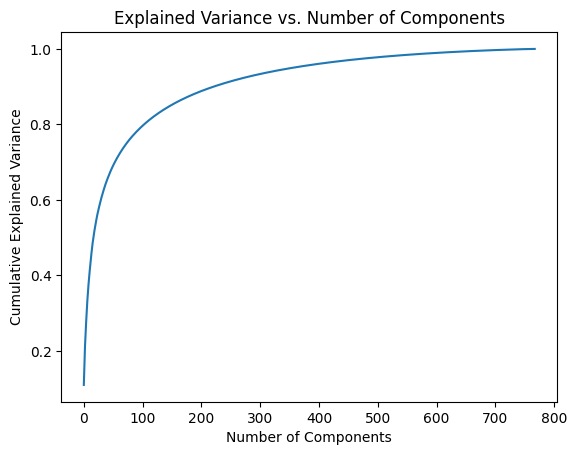

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [ ]:
commulative_var = np.cumsum(pca.explained_variance_ratio_)
# commulative_var

In [ ]:
threshold = 0.95
val = np.where(commulative_var >= threshold)[0][0]+1
val

356

- finding pca end
- pca = 356 cover 95% variance of data

- n_components using grid_search_cv - start

In [ ]:
dev_df_train = dev_df_train.drop('Unnamed: 0', axis = 1)

In [ ]:
# dev_df_train['converted_embedding'].iloc[0]

In [ ]:
# pipeline = Pipeline([
#     ('pca', PCA()),
#     ('tfidf', TfidfVectorizer()),
#     ('classifier', RandomForestClassifier())
# ])

# n_compo = [int(x) for x in np.linspace(start = 50, stop = 400, num = 100)]
# tfidf_features = [int(x) for x in np.linspace(start = 1000, stop = 10000, num = 1000)]

# param_grid = {
#     'pca__n_components': n_compo,
#     'tfidf__max_features': tfidf_features
# }

# text_tfidf_data = dev_df_train['text-tfidf']
# embedding_data = np.vstack(dev_df_train['converted_embedding'].to_numpy()) # convert embedding to numpy array
# X_data = np.hstack([embedding_data, text_tfidf_data.values.reshape(-1, 1)]) # stack tfidf horizionaly

# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     cv=5,
#     scoring='f1',
#     verbose=2,
#     n_jobs=-1
#     )

# grid_search.fit(X_data, dev_df_train['label'])

In [ ]:
print("Best n_components:", grid_search.best_params_['pca__n_components'])
print("Best tfidf features:", grid_search.best_params_['tfidf_best_features'])
print("Best F1-score:", grid_search.best_score_)
best_params = grid_search.best_params_

-- n_componets_using grid_search cv end

### VOATING CLASSIFIER [DT, RF, KNN, XGBoost]

In [ ]:
# test_data_ensmbl = pd.DataFrame({
#     'id': df_test['Sentence_id'],
#     'predictions': y_pred_ensmbl
# })
# # test_data_rfc_os = pd.DataFrame({
# #     'id': test_df['Sentence_id'],
# #     'predictions': predictions_rfc_os
# # })
# test_data_ensmbl['predictions'] = test_data_ensmbl['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# # test_data_rfc_os['predictions'] = test_data_rfc_os['predictions'].apply([lambda x: 'No' if x == 0 else 'Yes'])
# ## for LR
# test_data_merged_ensmbl = pd.merge(gold_test, test_data_ensmbl, left_on='Sentence_id', right_on='id', how='inner')
# # df_merged_rfc_os = pd.merge(gold_df, test_data_rfc_os, left_on='Sentence_id', right_on='id', how='inner')


# gold_labels_us = test_data_merged_ensmbl['class_label'].tolist()
# pred_labels_us = test_data_merged_ensmbl['predictions'].tolist()

# # gold_labels_os = df_merged_rfc_os['class_label'].tolist()
# # pred_labels_os = df_merged_rfc_os['predictions'].tolist()

# print(f"ENSEMBLED MODEL on balance dataset")
# acc = accuracy_score(gold_labels_us, pred_labels_us)
# precision = precision_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
# recall = recall_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')
# f1 = f1_score(gold_labels_us, pred_labels_us, pos_label='Yes', average='binary')

# # Print the metrics
# print(f"Accuracy: {acc:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

In [ ]:
y_train.value_couts()
# demo = y_train.tolist()
# print(demo)
# df_test.head(2)

AttributeError: 'Series' object has no attribute 'value_couts'

In [ ]:
y_test = gold_test['class_label'].map({'No': 0, 'Yes': 1})
# # y_test = y_test.apply([lambda x: 0 if x=='No' else 1])
# y_test = y_test.tolist()
# print(y_test)

In [ ]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [ ]:
y_test.shape

(341,)

In [ ]:
X_test.shape

(341, 4666)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Thesis/code/')
from voating_old import Ensemble

In [ ]:
y_train.value_counts()

,count
labels,
0,7189
1,5408


#- After prunning the data (Label = no, with no NER present in the text, transformer used to get th erelevent and noisy data using prompt engineering)
#- hyperparameter tuneed for XGBoost, Random Fores, Decision Tree, , KNN
#- encembling technique : Voating (yet to check bleending, stacking, with other model combinations )
#- Not resampled yet ( leter check with resampled data [over sampling, undersampling, overandundersampling, CT-GAN])



In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Thesis/code/voating.py')
from voating_old import Ensemble
obj = Ensemble(X_train, y_train.tolist(), X_test, y_test.tolist(), best_param_dt, best_param_xgb, best_param_rfc, best_param_knn)
obj.run_pipeline()

Accuracy: 0.80
Precision: 0.79
Recall: 0.80
F1 Score: 0.80


-

In [ ]:
# voatign classifier after data pruning (no resampling technique applied)
import sys
sys.path.append('/content/drive/MyDrive/Thesis/code/')
from voating import Ensemble
ensemble = Ensemble(X_train, y_train.tolist(), X_test, y_test.tolist(), best_param_dt, best_param_xgb, best_param_rfc, best_param_knn, best_param_gdb, best_param_lgbm, best_param_adb)
ensemble.run_pipeline()

......Voatinng Classifier.....
Classifiers used: ['dt', 'knn', 'rf', 'xgb']
Savnig this model.......
saved successfully....
Model Prerformance: _f1_0.796
Accuracy: 0.798
Precision: 0.794
Recall: 0.798
F1 Score: 0.796
Classifiers used: ['rf', 'xgb', 'dt', 'knn', 'gdb', 'lgbm', 'adb']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, re

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
Savnig this model.......
saved successfully....
Model Prerformance: _f1_0.823
Accuracy: 0.827
Precision: 0.821
Recall: 0.827
F1 Score: 0.823
Classifiers used: ['gdb', 'lgbm', 'adb']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, re

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6424202471887338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6424202471887338
[LightGBM] [Warning] lambda_l2 is set=0.6095643339798968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6095643339798968
[LightGBM] [Warning] lambda_l1 is set=0.036886947354532795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036886947354532795
[LightGBM] [Warning] bagging_fraction is set=0.856135294962221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.856135294962221
Savnig this model.......
saved successfully....
Model Prerformance: _f1_0.808
Accuracy: 0.809
Precision: 0.806
Recall: 0.809
F1 Score: 0.808
Classifiers used: ['dt', 'knn', 'rf', 'xgb', 'adb']
Savnig this model.......
saved successfully....
Model Prerformance: _f1_0.796
Accuracy: 0.801
Precision: 0.793
Recall: 0.801
F1 S

## voating end

In [ ]:
# 8.03.25
# different under sampled data: 4 data samplin technique X 7 hp tuned model => 28 models
train_resampling_set = {
    "rus": (X_train_u_balanced_rus, y_train_u_balanced_rus),
    "cnn": (X_train_u_balanced_cnn, y_train_u_balanced_cnn),
    "tml": (X_train_u_balanced_tml, y_train_u_balanced_tml),
    "enn": (X_train_u_balanced_enn, y_train_u_balanced_enn)
}
# eval_set = [X_eval, y_eval] # for gradient boostin models
train_models_set = {} # store the models for testing on gold dataset
model_set = {
    "rfc": (RandomForestClassifier(), best_param_rfc),
    "xgb": (XGBClassifier(), best_param_xgb),
    "dt": (DecisionTreeClassifier(), best_param_dt),
    "knn": (KNeighborsClassifier(), best_param_knn),
    "gdb": (GradientBoostingClassifier(), best_param_gdb),
    "lgbm": (LGBMClassifier(), best_param_lgbm),
    "adb": (AdaBoostClassifier(), best_param_adb)
}
for resampling_name, (X, y) in train_resampling_set.items():
  X_train = X
  y_train = y
  print("#"*50)
  print(f"-------dataset is resampled with {resampling_name}----------\n\n")
  print("-"*50)
  print(f"Shape of the data: {X_train.shape()}\n")
  print(f"Data sample from different class: {y_train.value_counts()}\n")
  print("-"*50)
  for name, (model, params) in model_set.items():
    print(f"Start {name} at {datetime.now().strftime('%I-%M-%S')} \n")
    try:
      print('-'*50)
      print(f"name: {name}")
      print(f"model: {model}, params: {params}")
      print('-'*50)
      model.set_params(**params)
      model.fit(X_train, y_train)
      train_models_set[name + resampling_name] = model
      print("--------------------Models in train_model_set-------------------\n")
      for k, v in train_models_set.items():
        print(f"{k}: {v}\n")
      print("-"*50)
      print(f"{name} trained successfully at {datetime.now().strftime('%I-%M-%S')}\n")
    except Exception as e:
      print(f"error for this {name}: {e}\n")


In [ ]:
m1 = DecisionTreeClassifier(**best_param_dtc)
m2 = RandomForestClassifier(**best_param_rfc)
m3 = KNeighborsClassifier(**best_param_knn)
m4 = XGBClassifier(**best_param_xgb)

#voting hard
vc_hard = VotingClassifier(estimators = [('dt', m1),('rfc', m2),('knn', m3),('xgb', m4)], voting = 'hard')
for resampling_name, (X, y) in train_resampling_set.items():
  X_train = X
  y_train = y
  print("#"*50)
  print(f"-------dataset is resampled with {resampling_name}----------\n\n")
  print("-"*50)
  print(f"Shape of the data: {X_train.shape()}\n")
  print(f"Data sample from different class: {y_train.value_counts()}\n")
  print("-"*50)

  vc_hard.fit(X_train, y_train)
  train_models_set[name + resampling_name] = model

  print("--------------------Models in train_model_set-------------------\n")
  for k, v in train_models_set.items():
    print(f"{k}: {v}\n")
    print("-"*50)

In [ ]:
m1 = DecisionTreeClassifier(**best_param_dtc)
m2 = RandomForestClassifier(**best_param_rfc)
m3 = KNeighborsClassifier(**best_param_knn)
m4 = XGBClassifier(**best_param_xgb)

#voting soft
vc_soft = VotingClassifier(estimators = [('dt', m1),('rfc', m2),('knn', m3),('xgb', m4)], voting = 'soft')
for resampling_name, (X, y) in train_resampling_set.items():
  X_train = X
  y_train = y
  print("#"*50)
  print(f"-------dataset is resampled with {resampling_name}----------\n\n")
  print("-"*50)
  print(f"Shape of the data: {X_train.shape()}\n")
  print(f"Data sample from different class: {y_train.value_counts()}\n")
  print("-"*50)

  vc_hard.fit(X_train, y_train)
  train_models_set[name + resampling_name] = model

  print("--------------------Models in train_model_set-------------------\n")
  for k, v in train_models_set.items():
    print(f"{k}: {v}\n")
    print("-"*50)

### stackingclassifier ()